# Pretrained Models

I'll try a couple of different pretrained modes. Just pop off the FC layers and add my own to get the predictions

In [1]:
from utils import *
from fastai import *

Using TensorFlow backend.


In [2]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import VGG16, VGG19, resnet50, xception
from keras.layers import GlobalAveragePooling2D
K.set_image_data_format('channels_last')

In [3]:
from keras.layers import GaussianNoise

In [4]:
from vis import *

In [5]:
#Paths
path = os.curdir + '/data/processed/'
train_json = path + 'train.json'

if os.path.exists(path + 'models/')==False:
    os.mkdir(path + 'models/')
model_path = path + 'models/'
if os.path.exists(path + 'results/')==False:
    os.mkdir(path + 'results/')
results_path = path + 'results/'

In [6]:
batch_size=64

In [7]:
val_data = load_array(path + 'val_data.bc')
trn_data = load_array(path + 'trn_data.bc')
val_labels = load_array(path + 'val_labels.bc')
trn_labels = load_array(path + 'trn_labels.bc')

In [8]:
#vgg = VGG16(include_top=False, input_shape=(75,75,3))
#vgg.layers.pop()
#vgg = Sequential(vgg.layers)

In [9]:
#trn_features = vgg.predict(trn_data, verbose=1)
#val_features = vgg.predict(val_data, verbose=1)

In [10]:
#save_array(results_path+'trn_features.bc', trn_features)
#save_array(results_path+'val_features.bc', val_features)

In [11]:
#trn_features = load_array(results_path+'trn_features.bc')
#val_features = load_array(results_path+'val_features.bc')

In [12]:
reduce_lr = ReduceLROnPlateau(patience=2)

In [13]:
#sample set masks
mskt = np.random.random(size=len(trn_data)) < 0.3
mskv = np.random.random(size=len(val_data)) < 0.3

In [14]:
#small sample sets for testing
vald = val_data[mskv]
trnd = trn_data[mskt]
vall = val_labels[mskv]
trnl = trn_labels[mskt]

## Validation and Visualizatation

First let's see what images it incorrectly classifies

In [172]:
#Get file names to load
filenames = val_batches.filenames

In [173]:
probs = model.predict_proba(val_features).squeeze()
preds = np.round(probs).squeeze()

50/50 [==============================] - 0s 2ms/step


In [174]:
def plots_idx(idx, titles=None):
    plots([image.load_img(val_path+filenames[i]) for i in idx], titles=titles)

n_view=4

Found 43 correct labels


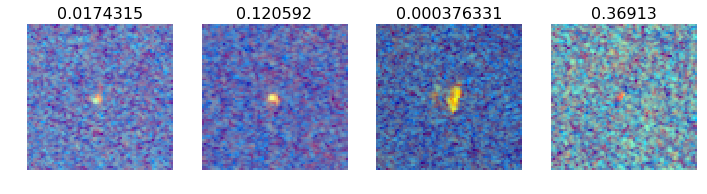

In [175]:
#some randomly selected correct labels
correct = np.where(preds==val_labels)[0]
print "Found %d correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

Found 7 incorrect labels


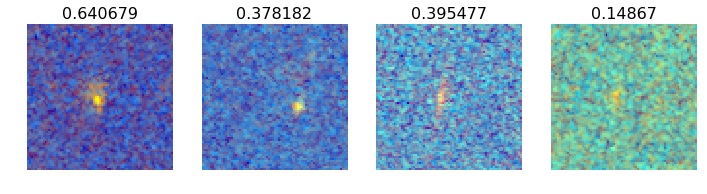

In [176]:
# some random incorrect labels
incorrect = np.where(preds!=val_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = np.random.permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

[[22  3]
 [ 4 21]]


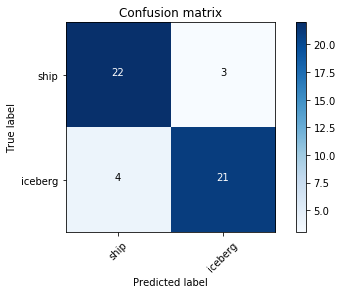

In [177]:
cm = confusion_matrix(val_labels,preds)
plot_confusion_matrix(cm, val_batches.class_indices)

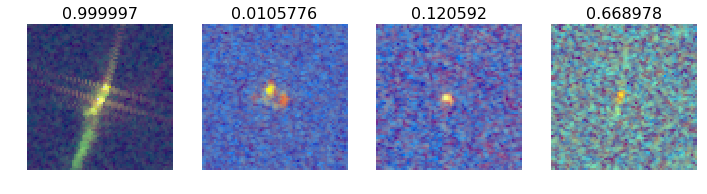

In [178]:
# the most certain correct labels
most_certain = np.argsort(-np.abs(probs[correct]-val_labels[correct]))
plots_idx(most_certain[:n_view], probs[most_certain])

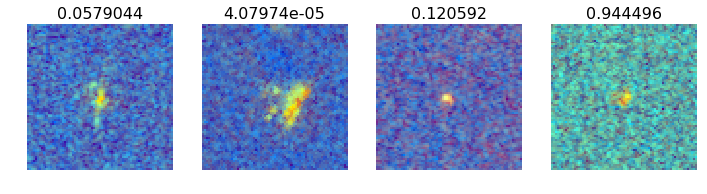

In [179]:
# the most certain incorrect labels
most_certain_incorrect = np.argsort(np.abs(probs[incorrect]-val_labels[incorrect]))
plots_idx(most_certain_incorrect[:n_view], probs[most_certain_incorrect])

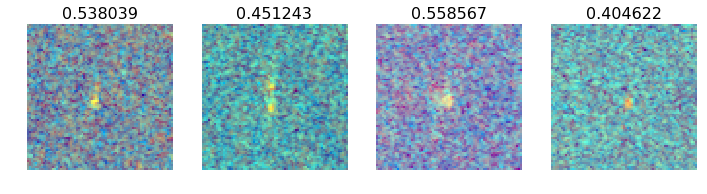

In [180]:
# the most uncertain labels
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:4], probs[most_uncertain])

## FCN Visualization

In [102]:
l = model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [103]:
from cv2 import resize

In [104]:
def get_cm(inp, label):
    conv = conv_fn([inp, 0])[0, label]
    return resize(conv, (224,224))

In [105]:
inp = np.expand_dims(val_features[27], 0)

In [107]:
np.round(model.predict(inp)[0], 2)

array([ 0.28], dtype=float32)

In [108]:
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))

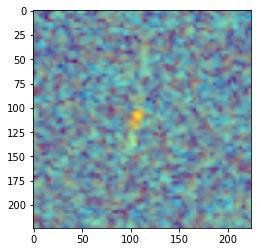

In [109]:
plt.imshow(to_plot(val_data[27]))

In [110]:
cm = get_cm(inp, 0)

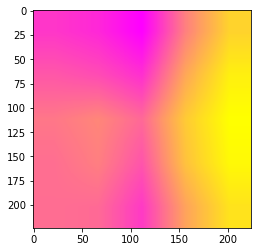

In [111]:
plt.imshow(cm, cmap="spring")

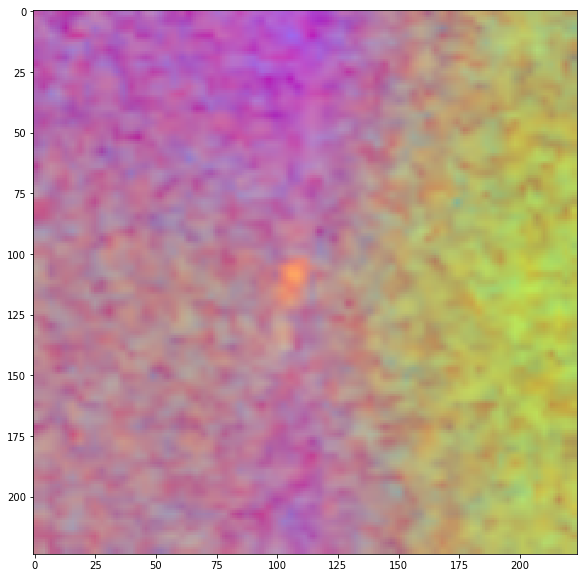

In [112]:
plt.figure(figsize=(10,10))
plot(val_data[27])
plt.imshow(cm, cmap="spring", alpha=0.5)

## Dense Layer

The images I'm using are very different from what VGG would have seen in imagenet, so I don't expect the dense layers alone to do a very good job. GlobalMaxPooling should do well because it will help to screen out the noisy background by only considering the strongest activations in the 512 feature channels

In [47]:
def dense2():
    model = Sequential([
        GlobalMaxPooling2D(input_shape=trn_features[0].shape),
        #MaxPooling2D(input_shape=trn_features[0].shape),
        #Flatten(),
        #Dense(32, activation='relu'),
        BatchNormalization(),
        #Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [48]:
model = dense2()

In [50]:
model.compile(optimizer=Adam(lr=1e-1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trn_features, trn_labels, batch_size=batch_size, epochs=8, verbose=1, callbacks=[reduce_lr],
         validation_data=(val_features, val_labels))

Train on 1283 samples, validate on 321 samples
Epoch 1/8
1283/1283 [==============================] - 0s 139us/step - loss: 1.4942 - acc: 0.7568 - val_loss: 1.5752 - val_acc: 0.7726
Epoch 2/8
1283/1283 [==============================] - 0s 137us/step - loss: 1.1921 - acc: 0.7966 - val_loss: 1.6998 - val_acc: 0.7508
Epoch 3/8
1283/1283 [==============================] - 0s 146us/step - loss: 1.3524 - acc: 0.7919 - val_loss: 2.0342 - val_acc: 0.7445
Epoch 4/8
1283/1283 [==============================] - 0s 139us/step - loss: 1.2102 - acc: 0.8067 - val_loss: 1.3858 - val_acc: 0.7882
Epoch 5/8
1283/1283 [==============================] - 0s 137us/step - loss: 1.0764 - acc: 0.7997 - val_loss: 1.4146 - val_acc: 0.7539
Epoch 6/8
1283/1283 [==============================] - 0s 139us/step - loss: 0.8202 - acc: 0.8176 - val_loss: 2.6645 - val_acc: 0.6854
Epoch 7/8
1283/1283 [==============================] - 0s 146us/step - loss: 1.1104 - acc: 0.7927 - val_loss: 1.7530 - val_acc: 0.7445
Epoch 8/

In [ ]:
model.save_weights(results_path + 'dense1.h5')

In [ ]:
model.load_weights(results_path + 'dense1.h5')

Global Max Pooling and GlobalAveragePooling seem to work pretty well in this model. However, loss seems really high for the level of accuracy. I'll probably need to retrain the convolutional layers.

## Fully Convolutional Network

Instead of using a sigmoid dense layer for the prediction I'll use convolutional layers. This architecture is shown to generalize well for images in which the target area is much smaller than the whole image

In [152]:
def get_fcn():
    model = Sequential([
        BatchNormalization(input_shape=trn_features[0].shape),
        #Flatten(),
        #Dense(512, activation='relu'),
        #BatchNormalization(),
        #Dropout(0.5),
        #Dense(512, activation='relu'),
        #BatchNormalization(),
        #Dropout(0.5),
        #Dense(1, activation='sigmoid')
        #MaxPooling2D(),
        Convolution2D(32, (3,3), padding='same', activation='relu'),
        #BatchNormalization(),
        #Dropout(0.5),
        Convolution2D(32, (3,3), padding='same', activation='relu'),
        #BatchNormalization(),
        #Dropout(0.5),
        Convolution2D(1, (3,3)),
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ])
    
    return model

In [153]:
model = get_fcn()

In [157]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [163]:
model.fit(trn_features, trn_labels, batch_size=batch_size, epochs=15, verbose=1, callbacks=[reduce_lr],
         validation_data=(val_features, val_labels))

Train on 1203 samples, validate on 401 samples
Epoch 1/15
1203/1203 [==============================] - 3s 3ms/step - loss: 0.2911 - acc: 0.8828 - val_loss: 0.3222 - val_acc: 0.8479
Epoch 2/15
1203/1203 [==============================] - 3s 3ms/step - loss: 0.2804 - acc: 0.8770 - val_loss: 0.3251 - val_acc: 0.8454
Epoch 3/15
1203/1203 [==============================] - 3s 3ms/step - loss: 0.2632 - acc: 0.8961 - val_loss: 0.3254 - val_acc: 0.8579
Epoch 4/15
1203/1203 [==============================] - 5s 4ms/step - loss: 0.2829 - acc: 0.8786 - val_loss: 0.3342 - val_acc: 0.8354
Epoch 5/15
1203/1203 [==============================] - 3s 2ms/step - loss: 0.2713 - acc: 0.8811 - val_loss: 0.3231 - val_acc: 0.8479
Epoch 6/15
1203/1203 [==============================] - 3s 3ms/step - loss: 0.2620 - acc: 0.8953 - val_loss: 0.3216 - val_acc: 0.8529
Epoch 7/15
1203/1203 [==============================] - 3s 2ms/step - loss: 0.2672 - acc: 0.8853 - val_loss: 0.3230 - val_acc: 0.8529
Epoch 8/15
1203

In [169]:
model.save_weights(results_path + 'fcn1.h5')

In [41]:
model.load_weights(results_path + 'fcn1.h5')

## Precomputed Augmentation

In [101]:
da_batches = get_batches(trn_path, gen, batch_size=batch_size, shuffle=True)

Found 1283 images belonging to 2 classes.


In [102]:
da_trn_features = vgg.predict_generator(da_batches, steps=len(da_batches)*5, verbose=1)

105/105 [==============================] - 4618s 44s/step


In [103]:
save_array(results_path+'da_trn_features.bc', da_trn_features)

In [104]:
da_trn_features = load_array(results_path+'da_trn_features.bc')

In [105]:
trn_conv_features = np.concatenate([trn_features, da_trn_features])

In [110]:
da_trn_labels = np.concatenate([trn_labels]*6)

In [113]:
model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trn_conv_features, da_trn_labels, batch_size=batch_size, epochs=15, verbose=1, callbacks=[reduce_lr],
         validation_data=(val_features, val_labels))

Train on 7698 samples, validate on 321 samples
Epoch 1/15
7698/7698 [==============================] - 14s 2ms/step - loss: 0.7347 - acc: 0.4992 - val_loss: 0.6877 - val_acc: 0.5732
Epoch 2/15
7698/7698 [==============================] - 14s 2ms/step - loss: 0.6943 - acc: 0.5083 - val_loss: 0.6881 - val_acc: 0.5732
Epoch 3/15
7698/7698 [==============================] - 14s 2ms/step - loss: 0.6943 - acc: 0.5126 - val_loss: 0.6856 - val_acc: 0.5732
Epoch 4/15
7698/7698 [==============================] - 15s 2ms/step - loss: 0.6937 - acc: 0.5177 - val_loss: 0.6866 - val_acc: 0.5732
Epoch 5/15
7698/7698 [==============================] - 14s 2ms/step - loss: 0.6946 - acc: 0.5103 - val_loss: 0.6891 - val_acc: 0.5732
Epoch 6/15
7698/7698 [==============================] - 14s 2ms/step - loss: 0.6934 - acc: 0.5145 - val_loss: 0.6871 - val_acc: 0.5732
Epoch 7/15
7698/7698 [==============================] - 14s 2ms/step - loss: 0.6926 - acc: 0.5166 - val_loss: 0.6886 - val_acc: 0.5732
Epoch 8/

KeyboardInterrupt: 

In [ ]:
model.save_weights(results_path + 'fcn1.h5')

In [ ]:
model.load_weights(results_path + 'fcn1.h5')

## Gaussian Noise Augmentation

In [46]:
from skimage.util import random_noise

In [47]:
def noise(data):
    noise = [random_noise(to_plot(image), 'speckle') for image in data]
    return noise

In [48]:
noise = noise(trn_data)

In [49]:
np.rollaxis(np.array(noise),3,1).shape

(200, 3, 224, 224)

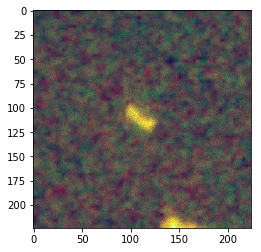

In [52]:
plt.imshow(noise[141])

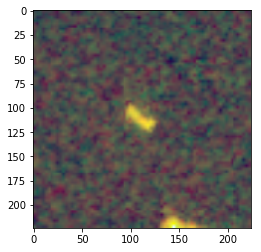

In [53]:
plt.imshow(to_plot(trn_data[141]))

In [274]:
noisy_trn_data = np.concatenate([trn_data, np.rollaxis(np.array(noise),3,1)])

In [276]:
noisy_trn_labels = np.concatenate([trn_labels,trn_labels])

In [284]:
noisy_trn_features = vgg.predict(noisy_trn_data, verbose=1)

400/400 [==============================] - 286s 715ms/step


In [285]:
noisy_trn_features.shape

(400, 512, 14, 14)

## Retraining Conv Layers

In [69]:
layers = vgg.layers
for layer in layers: layer.trainable=False

In [70]:
vgg.add(model)

In [71]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0         
__________

In [72]:
vgg.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
vgg.fit(trn_data, trn_labels, batch_size=32, epochs=1, verbose=1, validation_data=(val_data, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/1
200/200 [==============================] - 175s 876ms/step - loss: 1.2119 - acc: 0.6650 - val_loss: 0.8003 - val_acc: 0.6000


In [ ]:
model.save_weights(results_path+'vggfcn1.h5')

In [ ]:
model.load_weights(results_path+'vggfcn1.h5')

## Generator

In [82]:
#Data Augmentation
batches = get_batches(trn_path, gen, batch_size=32)

Found 200 images belonging to 2 classes.


In [87]:
gen_flow = gen.flow(trn_data, trn_labels)

In [89]:
vgg.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
vgg.fit_generator(gen_flow, steps_per_epoch=len(trn_data)/32, epochs=15, callbacks=[reduce_lr],
                    validation_data=(val_data, val_labels), validation_steps=len(val_data)/32)

Epoch 1/15
6/6 [==============================] - 155s 26s/step - loss: 0.5167 - acc: 0.7606 - val_loss: 0.4022 - val_acc: 0.8200
Epoch 2/15
6/6 [==============================] - 154s 26s/step - loss: 0.6723 - acc: 0.7102 - val_loss: 0.3908 - val_acc: 0.8000
Epoch 3/15
6/6 [==============================] - 156s 26s/step - loss: 0.4744 - acc: 0.7659 - val_loss: 0.3833 - val_acc: 0.8000
Epoch 4/15
6/6 [==============================] - 170s 28s/step - loss: 0.5586 - acc: 0.7344 - val_loss: 0.3783 - val_acc: 0.7800
Epoch 5/15
6/6 [==============================] - 139s 23s/step - loss: 0.6396 - acc: 0.6875 - val_loss: 0.3753 - val_acc: 0.7800
Epoch 6/15
6/6 [==============================] - 171s 28s/step - loss: 0.5988 - acc: 0.7031 - val_loss: 0.3741 - val_acc: 0.7600
Epoch 7/15
6/6 [==============================] - 155s 26s/step - loss: 0.5671 - acc: 0.7394 - val_loss: 0.3739 - val_acc: 0.7600
Epoch 8/15
6/6 [==============================] - 155s 26s/step - loss: 0.6073 - acc: 0.71

In [ ]:
model.save_weights(results_path+'fullfcn1da.h5')

In [ ]:
model.save_weights(results_path+'fullfcn1da.h5')

## ResNet18

In [17]:
from resnet import ResnetBuilder

In [18]:
K.set_image_data_format('channels_last')

In [19]:
rn = ResnetBuilder.build_resnet_18((3,75,75), 1)

In [20]:
act_out = rn.layers[-4].output

In [21]:
rn.layers[-4].output_shape

(None, 3, 3, 512)

In [22]:
base = Model(rn.input, act_out)

In [23]:
def get_top():
    p = Input(shape=(3,3,512))
    x = BatchNormalization()(p)
    x = Convolution2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    x = Convolution2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    x = Convolution2D(1, (3,3))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('sigmoid')(x)
    
    top = Model(p,x)
    
    return top

In [24]:
top = get_top()
full = top(base.output)
model = Model(base.input, full)
model.compile('Adam', 'binary_crossentropy', ['accuracy'])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 38, 38, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 38, 38, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 38, 38, 64)   0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
max_poolin

In [25]:
gen = image.ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1, rotation_range=0,
                               channel_shift_range=0.0, height_shift_range=0.1, zoom_range=0.1)
flow = gen.flow(trn_data, trn_labels, batch_size=batch_size)

In [26]:
model.compile(Adam(1e-3), 'binary_crossentropy', ['accuracy'])

In [32]:
model.fit(trnd, trnl, batch_size=batch_size, epochs=8, callbacks=[reduce_lr],
          validation_data=(vald, vall))

Train on 323 samples, validate on 130 samples
Epoch 1/8
323/323 [==============================] - 55s 169ms/step - loss: 1.0584 - acc: 0.8824 - val_loss: 7.5835 - val_acc: 0.5769
Epoch 2/8


KeyboardInterrupt: 

In [94]:
history1 = model.fit_generator(flow, steps_per_epoch=len(trn_data)/batch_size, epochs=8, callbacks=[reduce_lr],
       validation_data=(val_data, val_labels), validation_steps=len(val_data)/batch_size)

Epoch 1/8
18/18 [==============================] - 197s 11s/step - loss: 0.4118 - acc: 0.9080 - val_loss: 0.4427 - val_acc: 0.8978
Epoch 2/8
18/18 [==============================] - 186s 10s/step - loss: 0.3772 - acc: 0.9312 - val_loss: 0.4415 - val_acc: 0.8953
Epoch 3/8
18/18 [==============================] - 188s 10s/step - loss: 0.4152 - acc: 0.9123 - val_loss: 0.4406 - val_acc: 0.8903
Epoch 4/8
18/18 [==============================] - 189s 10s/step - loss: 0.4027 - acc: 0.9197 - val_loss: 0.4402 - val_acc: 0.8903
Epoch 5/8
18/18 [==============================] - 191s 11s/step - loss: 0.3957 - acc: 0.9184 - val_loss: 0.4397 - val_acc: 0.8878
Epoch 6/8


KeyboardInterrupt: 

In [216]:
save_array(results_path+'rn_trn_features.bc', rn_trn_features)
save_array(results_path+'rn_val_features.bc', rn_val_features)

In [217]:
rn_trn_features = load_array(results_path+'rn_trn_features.bc')
rn_val_features = load_array(results_path+'rn_val_features.bc')

In [218]:
def rn_top():
    rn_top = Sequential([
        Flatten(input_shape=rn_trn_features[0].shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return rn_top

In [219]:
rn_top = rn_top()

In [220]:
rn_trn_features.shape

(200, 2048, 1, 1)

In [92]:
rn_top.compile(optimizer=Adam(lr=1e-10), loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'rn_top' is not defined

In [236]:
rn_top.fit(rn_trn_features, trn_labels, batch_size=batch_size, epochs=3,
           validation_data=(rn_val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/3
200/200 [==============================] - 0s 143us/step - loss: 0.3487 - acc: 0.8450 - val_loss: 0.2944 - val_acc: 0.8800
Epoch 2/3
200/200 [==============================] - 0s 143us/step - loss: 0.3867 - acc: 0.8200 - val_loss: 0.2945 - val_acc: 0.8800
Epoch 3/3
200/200 [==============================] - 0s 143us/step - loss: 0.4054 - acc: 0.8150 - val_loss: 0.2945 - val_acc: 0.8800


In [237]:
rn_top.save_weights(results_path + 'rn1.h5')

In [238]:
rn_top.load_weights(results_path + 'rn1.h5')

## Xception

In [29]:
ex = xception.Xception(include_top=False, input_shape=(224,224,3))

In [30]:
ex_trn_features = ex.predict(trn_data, batch_size=batch_size, verbose=1)
ex_val_features = ex.predict(val_data, batch_size=batch_size, verbose=1)

50/50 [==============================] - 52s 1s/step


In [31]:
save_array(results_path+'ex_trn_features.bc', ex_trn_features)
save_array(results_path+'ex_val_features.bc', ex_val_features)

In [32]:
ex_trn_features = load_array(results_path+'ex_trn_features.bc')
ex_val_features = load_array(results_path+'ex_val_features.bc')

In [71]:
def ex_top():
    ex_top = Sequential([
        BatchNormalization(input_shape=ex_trn_features[0].shape),
        MaxPooling2D(),
        ZeroPadding2D(),
        Convolution2D(16,(3,3), activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Convolution2D(1, (3,3)),
        GlobalMaxPooling2D(),
        Activation('sigmoid')
    ])
    
    return ex_top

In [72]:
ex_top = ex_top()

In [73]:
ex_top.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
ex_top.fit(ex_trn_features, trn_labels, batch_size=batch_size, epochs=15, verbose=1, callbacks=[reduce_lr],
          validation_data=(ex_val_features, val_labels))

Train on 200 samples, validate on 50 samples
Epoch 1/15
200/200 [==============================] - 2s 11ms/step - loss: 0.8884 - acc: 0.6050 - val_loss: 4.0824 - val_acc: 0.6600
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 0.6579 - acc: 0.6500 - val_loss: 3.3835 - val_acc: 0.7000
Epoch 3/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4316 - acc: 0.7550 - val_loss: 4.0610 - val_acc: 0.6600
Epoch 4/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4659 - acc: 0.7650 - val_loss: 3.6231 - val_acc: 0.6600
Epoch 5/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4368 - acc: 0.7650 - val_loss: 2.6989 - val_acc: 0.6800
Epoch 6/15
200/200 [==============================] - 2s 8ms/step - loss: 0.4260 - acc: 0.7450 - val_loss: 1.6993 - val_acc: 0.7000
Epoch 7/15
200/200 [==============================] - 2s 8ms/step - loss: 0.3613 - acc: 0.8200 - val_loss: 1.1960 - val_acc: 0.7200
Epoch 8/15
200/200 [==========

## Data Augmentation

The goal in this section is to create a general method that will take the top model and attach it to the base model so that I can do data augmentation and retrain the convolution layers for this particular problem.

## SEResNet

In [91]:
from se_resnet import SEResNet18, SEResNet50, SEResNet101

In [142]:
sr = SEResNet101(input_shape=(75,75,3), include_top=False, weights='imagenet')

In [139]:
def get_top():
    p = Input(shape=(3,3,2048))
    #x = GlobalAveragePooling2D()(p)
    #x = Dense(1, activation='sigmoid')(x)
    x = BatchNormalization()(p)
    #x = Flatten()(x)
    #x = Dense(512, activation='relu')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(512, activation='relu')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(1, activation='sigmoid')(x)
    x = Convolution2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    x = Convolution2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    x = Convolution2D(1, (3,3))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('sigmoid')(x)
    
    top = Model(p,x)
    
    return top

In [140]:
top = get_top()
full = top(sr.output)
model = Model(sr.input, full)
model.compile('Adam', 'binary_crossentropy', ['accuracy'])

In [20]:
model.fit(trn_data, trn_labels, batch_size=batch_size, epochs=5, callbacks=[reduce_lr],
       validation_data=(val_data,val_labels))

Train on 1203 samples, validate on 401 samples
Epoch 1/5
1203/1203 [==============================] - 506s 420ms/step - loss: 0.5891 - acc: 0.7423 - val_loss: 6.8265 - val_acc: 0.5262
Epoch 2/5
 512/1203 [===========>..................] - ETA: 4:18 - loss: 0.1944 - acc: 0.9277

KeyboardInterrupt: 

In [54]:
model.save_weights(path+'resnet18.h5')

In [141]:
model.load_weights(path+'resnet18.h5')

ValueError: Layer #53 (named "model_8" in the current model) was found to correspond to layer model_7 in the save file. However the new layer model_8 expects 18 weights, but the saved weights have 2 elements.

In [23]:
gen = image.ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05, rotation_range=0,
                               channel_shift_range=0.0, height_shift_range=0.05, zoom_range=0.05)
flow = gen.flow(trn_data, trn_labels, batch_size=batch_size)

In [27]:
model.compile(Adam(1e-5), 'binary_crossentropy', ['accuracy'])

In [28]:
model.fit_generator(flow, steps_per_epoch=len(trn_data)/batch_size, epochs=8, callbacks=[reduce_lr],
                    validation_data=(val_data, val_labels), validation_steps=len(val_data)/batch_size)

Epoch 1/8
18/18 [==============================] - 500s 28s/step - loss: 0.2847 - acc: 0.8624 - val_loss: 0.6778 - val_acc: 0.6509
Epoch 2/8
18/18 [==============================] - 487s 27s/step - loss: 0.2475 - acc: 0.8934 - val_loss: 0.6644 - val_acc: 0.6185
Epoch 3/8
18/18 [==============================] - 520s 29s/step - loss: 0.2390 - acc: 0.9062 - val_loss: 0.6796 - val_acc: 0.5935
Epoch 4/8
18/18 [==============================] - 500s 28s/step - loss: 0.2217 - acc: 0.9141 - val_loss: 0.6843 - val_acc: 0.5910
Epoch 5/8
18/18 [==============================] - 479s 27s/step - loss: 0.2287 - acc: 0.9071 - val_loss: 0.6420 - val_acc: 0.6035
Epoch 6/8
18/18 [==============================] - 489s 27s/step - loss: 0.2195 - acc: 0.9132 - val_loss: 0.6146 - val_acc: 0.6284
Epoch 7/8
18/18 [==============================] - 486s 27s/step - loss: 0.2360 - acc: 0.9008 - val_loss: 0.5880 - val_acc: 0.6584
Epoch 8/8
18/18 [==============================] - 492s 27s/step - loss: 0.2209 - a

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 38, 38, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 19, 19, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 19, 19, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
activation

In [42]:
copy_weights(model.layers[:-1], sr.layers)

In [43]:
sr.save_weights(path+'rsqnet50_topless.h5')

In [143]:
trn_features = sr.predict(trn_data, verbose=1, batch_size=64)
val_features = sr.predict(val_data, verbose=1, batch_size=64)

401/401 [==============================] - 93s 233ms/step


In [120]:
trn_features.shape

(1203, 3, 3, 512)

In [174]:
def make_model():
    model = Sequential([
        BatchNormalization(input_shape=(3,3,2048)),
        #Dropout(0.5),
        #Flatten(),
        #Dense(512, activation='relu'),
        #BatchNormalization(),
        #Dropout(0.8),
        #Dense(512, activation='relu'),
        #BatchNormalization(),
        #Dropout(0.8),
        #Conv2D(64, (3,3), padding='same', activation='relu'),
        #Conv2D(64, (3,3), padding='same', activation='relu'),
        #BatchNormalization(),
        #MaxPooling2D(),
        #Dropout(0.75),
        #Conv2D(32, (3,3), padding='same', activation='relu'),
        #Conv2D(32, (3,3), padding='same', activation='relu'),
        #BatchNormalization(),
        #Dropout(0.75),
        #Convolution2D(1, (1,1), padding='same'),
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
        #Activation('sigmoid')
    ])
    
    return model

In [175]:
mod = make_model()

In [176]:
mod.compile('Adam', 'binary_crossentropy', ['accuracy'])

In [177]:
history1 = mod.fit(trn_features, trn_labels, batch_size=batch_size, epochs=1, verbose=1, callbacks=[reduce_lr],
                   validation_data=(val_features, val_labels))

Train on 1203 samples, validate on 401 samples
Epoch 1/1
1203/1203 [==============================] - 9s 8ms/step - loss: 0.6439 - acc: 0.6276 - val_loss: 0.9558 - val_acc: 0.4663


In [173]:
from tqdm import tqdm

In [ ]:
epochs = 10
batch_size = 64
gen = image.ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1, rotation_range=0,
                               channel_shift_range=0.0, height_shift_range=0.1, zoom_range=0)
#gen_flow = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=False)
#try:
for e in range(epochs):
    print('-'*40)
    for b in tqdm(range(18)):
        f = b * batch_size
        l = (b+1) * batch_size
        #print('at gen flow')
        gen_flow = gen.flow(np.array(trn_data[f:l]), np.array(trn_labels[f:l]), batch_size=batch_size, shuffle=False)
        #print('at trn_batch')
        trn_batch = np.array(next(gen_flow)[0])
        #print('at vgg trn batch')
        rn_trn_batch = sr.predict(trn_batch, steps=1)
        #print('at ex trn batch')
        #ex_trn_batch = ex.predict(trn_batch, steps=1)
        #print('at batch label')
        batch_label = np.array(trn_labels[f:l])
            
        mod.train_on_batch(rn_trn_batch, batch_label)

    print("")
    lossv = mod.evaluate(val_features, val_labels, verbose=1)
    losst = mod.evaluate(trn_features, trn_labels, verbose=1)
    print('Epoch: {0} | Loss-v: {1} | Loss-t: {2}'.format(e, lossv, losst))
        
#except KeyboardInterrupt:
    #pass

  0%|          | 0/18 [00:00<?, ?it/s]

----------------------------------------


100%|██████████| 18/18 [04:31<00:00, 15.08s/it]


128/401 [========>.....................] - ETA: 0s

1203/1203 [==============================] - 1s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0 | Loss-v: [0.54492854477461439, 0.76059850448384847] | Loss-t: [0.53659318584456406, 0.76641728971168976]
----------------------------------------


100%|██████████| 18/18 [04:30<00:00, 15.03s/it]


160/401 [==========>...................] - ETA: 0s

1203/1203 [==============================] - 1s 975us/step


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 | Loss-v: [0.53652507126182691, 0.75561097331177862] | Loss-t: [0.52822027564147855, 0.77389858646979459]
----------------------------------------


100%|██████████| 18/18 [04:32<00:00, 15.12s/it]


160/401 [==========>...................] - ETA: 0s

1203/1203 [==============================] - 1s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 | Loss-v: [0.51939831484582955, 0.7680798010933132] | Loss-t: [0.51158201991768548, 0.78304239396541597]
----------------------------------------


100%|██████████| 18/18 [04:32<00:00, 15.14s/it]


128/401 [========>.....................] - ETA: 0s

1203/1203 [==============================] - 1s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3 | Loss-v: [0.50904394816282084, 0.78054862902348776] | Loss-t: [0.50020560173817896, 0.78553615955145084]
----------------------------------------


100%|██████████| 18/18 [04:33<00:00, 15.21s/it]


160/401 [==========>...................] - ETA: 0s

1203/1203 [==============================] - 1s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4 | Loss-v: [0.5068777646507111, 0.77805486343745278] | Loss-t: [0.49458217383025588, 0.78221113877007098]
----------------------------------------


  6%|▌         | 1/18 [00:15<04:27, 15.74s/it]